In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun
import scipy.stats as stats
import scipy.optimize as optimize
import warnings

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Architecture,n_fit,Min Loss,Mean Loss,Std Loss
0,Vanilla,100,4.404200,4.427100,0.028100
1,Vanilla,1000,4.397000,4.402100,0.006500
2,Vanilla,10000,4.396800,4.398100,0.002200
3,Vanilla,100000,4.400500,4.400700,0.000300
4,Capped Base Stock,100,4.405400,4.415500,0.020100
5,Capped Base Stock,1000,4.405400,4.425600,0.023200
6,Capped Base Stock,10000,4.405400,4.405400,0.000000
7,Capped Base Stock,100000,4.405400,4.405400,0.000000


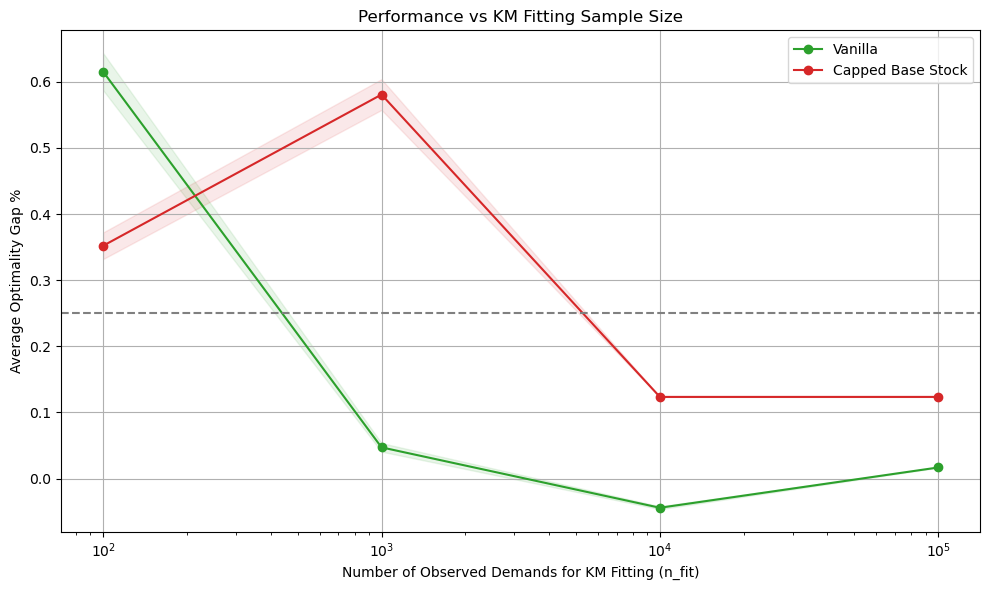

In [5]:
# Define color scheme for architecture types
color_scheme = {
    "Vanilla": "#2ca02c",  # Green
    "Capped Base Stock": "#d62728",  # Red
}

linestyle_scheme = {
    "Vanilla": "-",  # Solid
    "Capped Base Stock": "-",  # Solid
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_lead_time':
        return 2
    return None
sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Define n_fit values and paths
n_fit_values = [10**2, 10**3, 10**4, 10**5]
path = 'censored_demands_kaplanmeier'
vanilla_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_one_store/'
}
capped_base_stock_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}/capped_base_stock/'
}

optimal_loss = 4.40  # Using lead time 2 optimal loss

# For each architecture type
for arch, paths in [("Vanilla", vanilla_paths), ("Capped Base Stock", capped_base_stock_paths)]:
    performance_data = []
    std_data = []
    
    # Get data for all n_fit values
    df = results_interpretor.make_table(paths,
        {'kaplanmeier_n_fit': n_fit_values,
         'store_lead_time': [2],
         'samples': [1, 2, 3, 4],
         'censor_demands_for_train_and_dev': ['kaplanmeier']},
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    
    # Calculate average performance and std for each n_fit
    for n_fit in n_fit_values:
        # Get rows for this n_fit
        n_fit_rows = df[df['kaplanmeier_n_fit'] == n_fit]
        
        # Calculate average test loss and std across samples
        avg_performance = n_fit_rows['Test Loss'].mean()
        std_performance = n_fit_rows['Test Loss'].std()
        
        optimality_gap = ((avg_performance - optimal_loss) / optimal_loss) * 100
        std_gap = std_performance  # Keep raw standard deviation without normalizing
        
        performance_data.append(optimality_gap)
        std_data.append(std_gap)
    
    # Plot results with std shading
    ax.plot(n_fit_values, performance_data, 
            marker='o', label=arch,
            color=color_scheme[arch],
            linestyle=linestyle_scheme[arch])
            
    # Add shaded region for standard deviation
    ax.fill_between(n_fit_values, 
                   np.array(performance_data) - np.array(std_data),
                   np.array(performance_data) + np.array(std_data),
                   color=color_scheme[arch], alpha=0.1)

ax.set_xscale('log')
ax.set_xlabel('Number of Observed Demands for KM Fitting (n_fit)')
ax.set_ylabel('Average Optimality Gap %')
ax.set_title('Performance vs KM Fitting Sample Size')
ax.grid(True)
ax.legend()

# Create summary statistics table
summary_data = []
for arch, paths in [("Vanilla", vanilla_paths), ("Capped Base Stock", capped_base_stock_paths)]:
    df = results_interpretor.make_table(paths,
        {'kaplanmeier_n_fit': n_fit_values,
         'store_lead_time': [2],
         'samples': [1, 2, 3, 4],
         'censor_demands_for_train_and_dev': ['kaplanmeier']},
        default_condition_setter, custom_data_filler,
        sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
    
    for n_fit in n_fit_values:
        n_fit_rows = df[df['kaplanmeier_n_fit'] == n_fit]
        stats = n_fit_rows['Test Loss'].agg(['min', 'mean', 'std']).round(4)
        summary_data.append({
            'Architecture': arch,
            'n_fit': n_fit,
            'Min Loss': stats['min'],
            'Mean Loss': stats['mean'], 
            'Std Loss': stats['std']
        })

summary_df = pd.DataFrame(summary_data)
display(summary_df.style.set_caption("Summary Statistics by Architecture and n_fit"))

# Add 0.25% optimality gap reference line
ax.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.tight_layout()
plt.show()

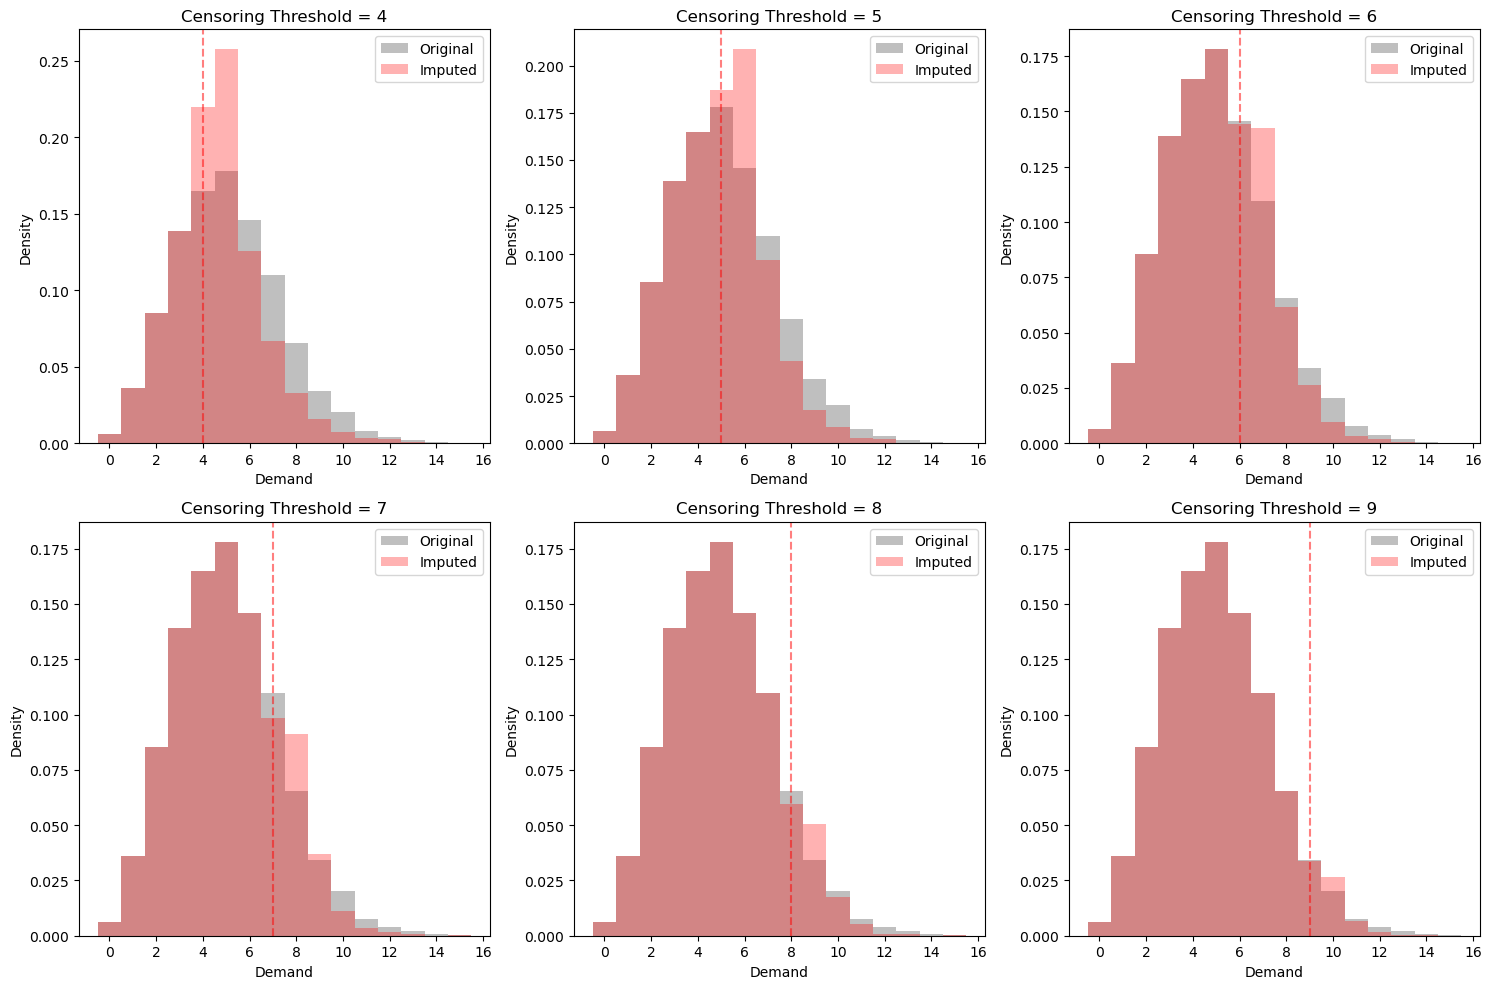

In [27]:
import scipy.stats as stats
import scipy.optimize as optimize
class PoissonDemandGenerator:
    def __init__(self, num_samples, periods):
        self.num_samples = num_samples
        self.periods = periods

    def estimate_exponential_tail_rate(self, samples, M, n_tail_buckets=3):
        flat_samples = samples.flatten()

        tail_samples = flat_samples[(flat_samples >= M-n_tail_buckets) & (flat_samples < M)]
        
        def neg_log_likelihood(rate):
            return -np.sum(np.log(stats.expon.pdf(tail_samples - (M-n_tail_buckets), scale=1/rate)))
        result = optimize.minimize_scalar(neg_log_likelihood, bounds=(0.01, 10), method='bounded')
        
        return result.x

    def generate_censored_demand(self, problem_params, demand_params, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        M = problem_params.get('censoring_threshold', 7)
        
        orig_samples = np.random.poisson(
            demand_params['mean'], 
            size=(self.num_samples, problem_params['n_stores'], self.periods)
        )
        imputed_samples = np.minimum(orig_samples, M)
        censored_mask = orig_samples >= M
        lambda_exp = self.estimate_exponential_tail_rate(orig_samples, M)
        censored_tails = np.round(
            M + np.random.exponential(1/lambda_exp, size=np.sum(censored_mask))
        ).astype(int)
        
        imputed_samples[censored_mask] = censored_tails
        return orig_samples, imputed_samples

# Create plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
thresholds = [4, 5, 6, 7, 8, 9]

generator = PoissonDemandGenerator(num_samples=8192, periods=1)
demand_params = {'mean': 5.0}

for i, M in enumerate(thresholds):
    row = i // 3
    col = i % 3
    
    problem_params = {'censoring_threshold': M, 'n_stores': 1}
    orig, imputed = generator.generate_censored_demand(problem_params, demand_params, seed=57)
    
    # Flatten arrays for histogram
    orig_flat = orig.flatten()
    imputed_flat = imputed.flatten()
    
    # Plot histograms
    bins = np.arange(0, max(orig_flat.max(), imputed_flat.max()) + 2) - 0.5
    axs[row, col].hist(orig_flat, bins=bins, alpha=0.5, density=True, label='Original', color='grey')
    axs[row, col].hist(imputed_flat, bins=bins, alpha=0.3, density=True, label='Imputed', color='red')
    
    # Add vertical line at threshold
    axs[row, col].axvline(x=M, color='r', linestyle='--', alpha=0.5)
    
    axs[row, col].set_title(f'Censoring Threshold = {M}')
    axs[row, col].set_xlabel('Demand')
    axs[row, col].set_ylabel('Density')
    axs[row, col].legend()

plt.tight_layout()
plt.show()